# Investigate default simulations for wilting point, field capacity and saturated soil moisture content

Inne Vanderkelen - October 2023

## 1. Settings

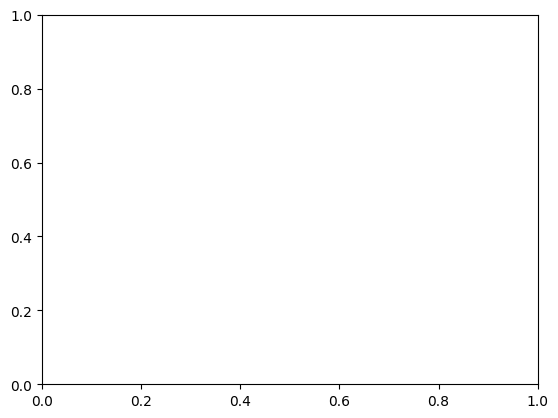

In [1]:
# laod modules 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github .com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [3]:
# case settings

# define scenario
scenario = '4p1000'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario

case   = case_ctl
block  = 'lnd' 
stream = 'h0' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ["H2OSOI","watsat", "watfc"]

# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 # 2028 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-01")

## 2. Load data

### Load simulations

In [4]:
ds_ctl = import_case(case_ctl, myVars=variables, timeSlice=time_slice)

In [5]:
ds_scen = import_case(case_scen, myVars=variables, timeSlice=time_slice)

In [6]:
ds_delta = ds_scen - ds_ctl 

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [7]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

In [8]:
# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

In [9]:
# get masks for sandy and clay soils

# define tresholds for pct sand and pct clay
pct_sand_threshold_min = 50
pct_sand_threshold_max = 85
pct_clay_threshold = 40
da_sand_mask, da_clay_mask = get_texture_masks(pct_sand_threshold_max,pct_sand_threshold_min,  pct_clay_threshold, ds_input, levsoi_thickness)



In [10]:
# wilting point
# load precalculated wilting point datasets
da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario) 

### Plotting settings

In [11]:
## settings

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

plotting_depth = 2 # m 8
figsize = (17,38)


In [12]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list_crops = [15,16]
pft_list_grassland = [0,12,13,14]

## 3. Analysis & plotting


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x1554f2f31870> (for post_execute):



KeyboardInterrupt



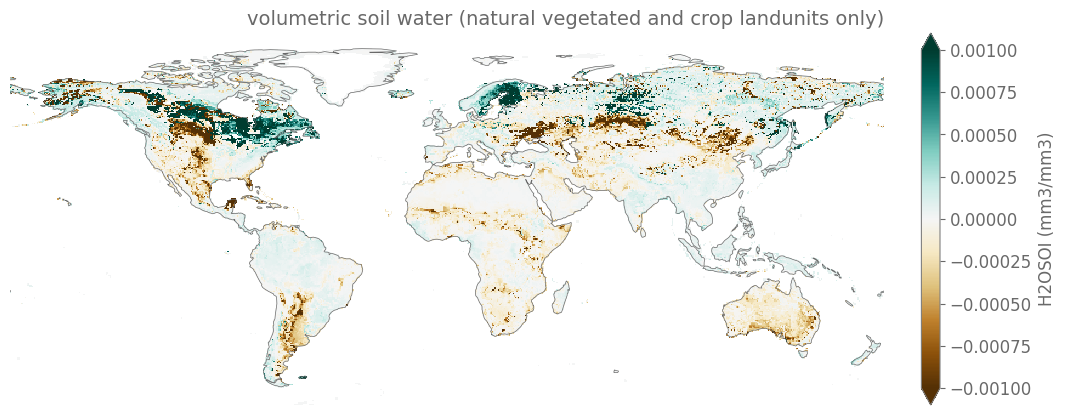

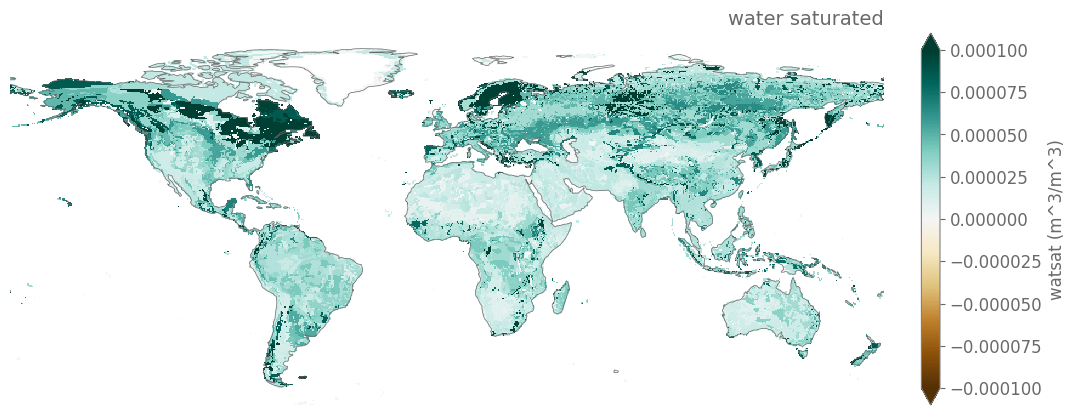

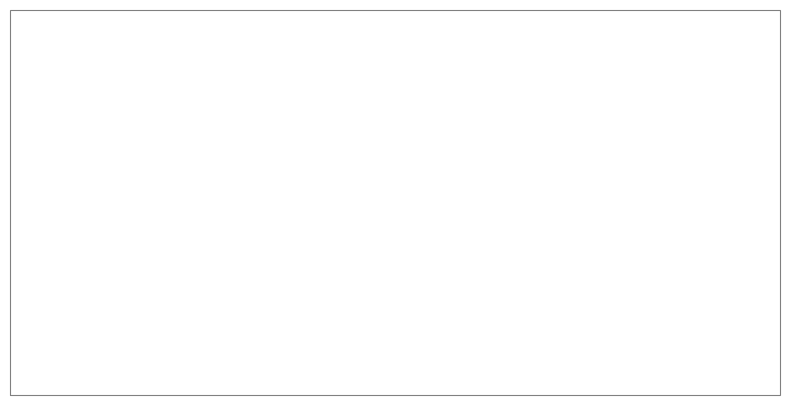

In [13]:
d_vlims = {"watfc"         : [-0.0001,0.0001], 
           "watsat"        : [-0.0001,0.0001], 
           "H2OSOI"         : [-0.001,0.001],
           "H2OSOI_WILT"  : [-0.01,0.01]}

for i, variable in enumerate(variables): 

    calc_plot_delta(ds_delta, ds_ctl, variable, d_vlims)
    
    
variable = 'H2OSOI_WILT'

# plot this variable seperate
da_delta =  da_wilting_h2osoi_scen - da_wilting_h2osoi

if 'levsoi' in da_delta.dims: 
    da_delta = da_delta.weighted(da_delta['levsoi']).mean(dim='levsoi')

da_delta.attrs = {'long_name': 'permanent wilting point', 'units': 'm^3/m^3'}

vlims=d_vlims[variable]

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

da_delta.plot(ax=ax, cmap='BrBG', vmin=vlims[0], vmax=vlims[1], extend='both',  cbar_kwargs={'label': da_delta.name+' ('+da_delta.units+')', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)

ax.set_title(da_delta.long_name, loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')
    

In [88]:
# calculate difference in water holding capacity. 

# delta field capacity
da_fc_ctl =  ds_ctl['watfc'][:,0:10,:,:].rename({'levgrnd':'levsoi'})
da_fc_scen =  ds_scen['watfc'][:,0:10,:,:].rename({'levgrnd':'levsoi'})

da_fc_ctl['levsoi'] = da_wilting_h2osoi_scen['levsoi']
da_fc_scen['levsoi'] = da_wilting_h2osoi_scen['levsoi']

da_whc_ctl =  (da_fc_ctl - da_wilting_h2osoi)
da_whc_scen = (da_fc_scen  - da_wilting_h2osoi_scen)

# delta wilting point
da_delta_whc =  da_whc_scen - da_whc_ctl
da_delta_whc = da_delta_whc.weighted(da_delta_whc['levsoi']).mean(dim='levsoi')
da_whc_ctl= da_whc_ctl.weighted(da_whc_ctl['levsoi']).mean(dim='levsoi')

# delta between the delta's


(-180.0, 180.0, -63.0, 90.0)

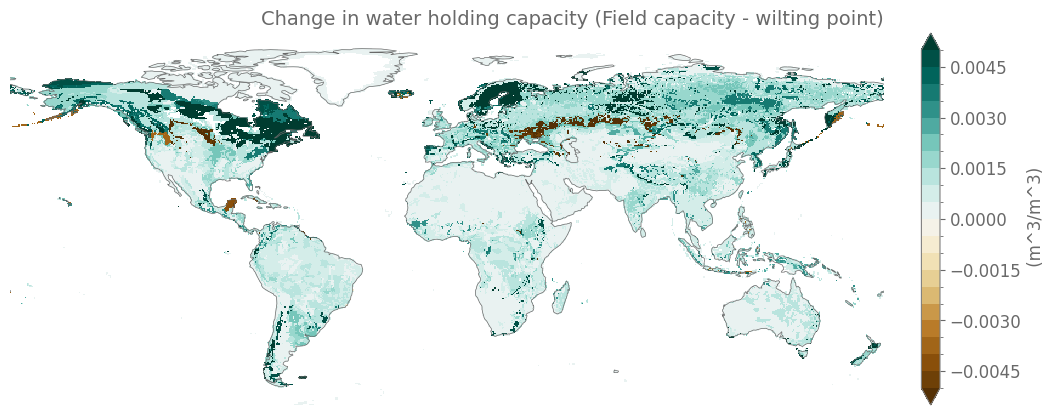

In [89]:
# plot water holding capacity of the soil (FC - permanent wilting point) 


da_delta_whc.attrs = {'long_name': 'Change in water holding capacity (Field capacity - wilting point)', 'units': 'm^3/m^3'}

vlims=[-0.005,0.005]

levels = np.arange(-0.005,0.0055,0.0005)
plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

da_delta_whc.mean('time').plot(ax=ax, cmap='BrBG', levels=levels,  extend='both',  cbar_kwargs={'label':' ('+da_delta_whc.units+')', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)

ax.set_title(da_delta_whc.long_name, loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')
    

(-180.0, 180.0, -63.0, 90.0)

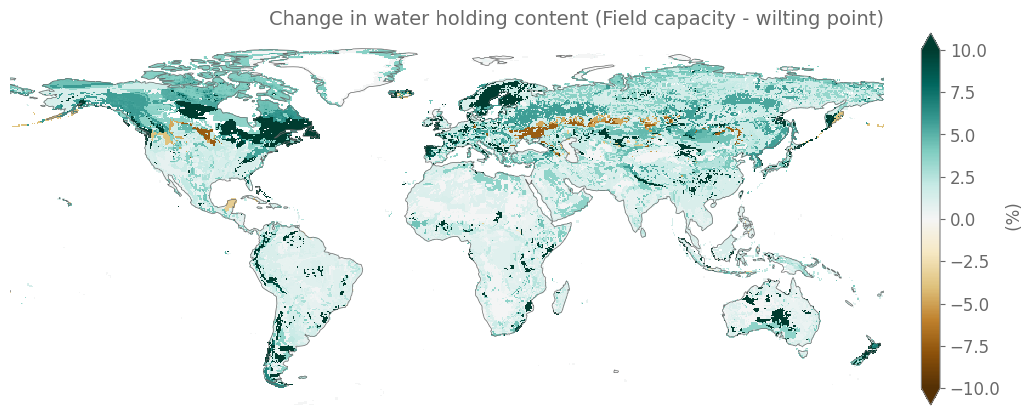

In [90]:
# plot water holding capacity of the soil (FC - permanent wilting point) 

da_delta_whc.attrs = {'long_name': 'Change in water holding content (Field capacity - wilting point)', 'units': 'm^3/m^3'}

vlims=[-10,10]

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

((da_delta_whc/abs(da_whc_ctl)).mean('time')*100).plot(ax=ax, cmap='BrBG', extend='both',  vmin=vlims[0], vmax=vlims[1],  cbar_kwargs={'label':' (%)', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)

ax.set_title(da_delta_whc.long_name, loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')
    

(-180.0, 180.0, -63.0, 90.0)

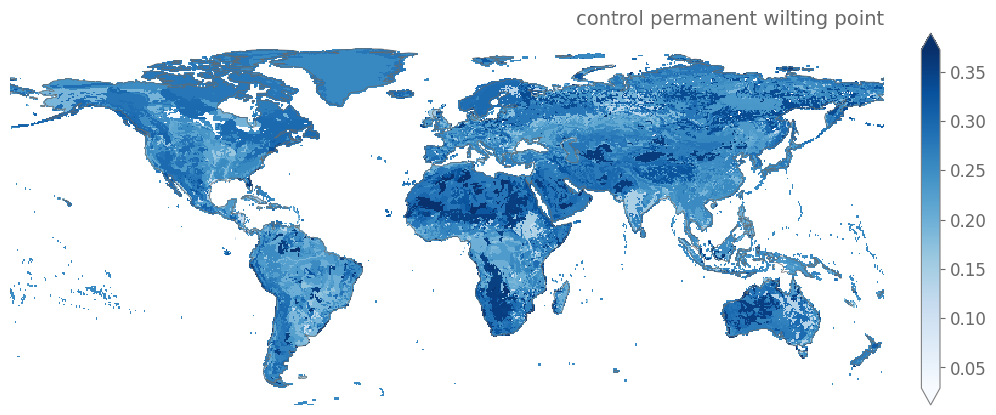

In [76]:
vlims=d_vlims[variable]

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

da_wilting_h2osoi.weighted(da_wilting_h2osoi['levsoi']).mean(dim='levsoi').plot(ax=ax, cmap='Blues', extend='both',  cbar_kwargs={'fraction': 0.02, 'pad': 0.04}, add_labels=False)

ax.set_title('control permanent wilting point', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')
    

(-180.0, 180.0, -63.0, 90.0)

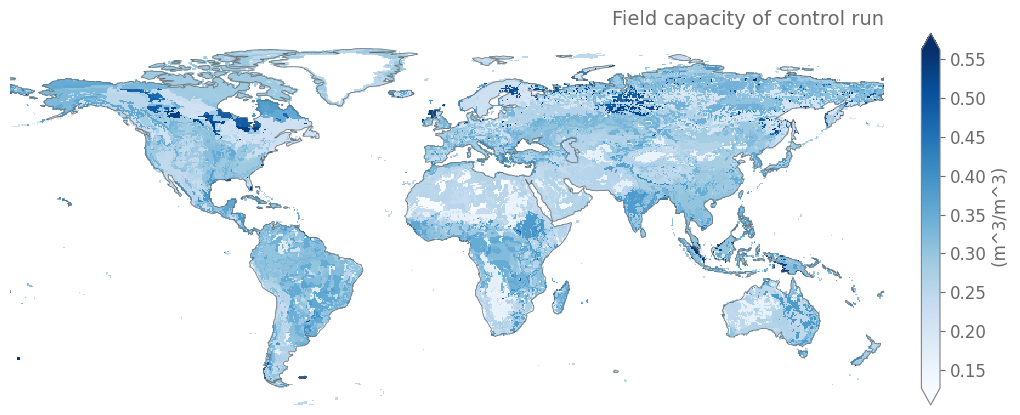

In [77]:
vlims=d_vlims[variable]

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

da_fc_ctl.mean('time').weighted(da_wilting_h2osoi['levsoi']).mean(dim='levsoi').plot(ax=ax, cmap='Blues', extend='both',  cbar_kwargs={'label': ' ('+da_fc_ctl.units+')', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)

ax.set_title('Field capacity of control run', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')
    

(-180.0, 180.0, -63.0, 90.0)

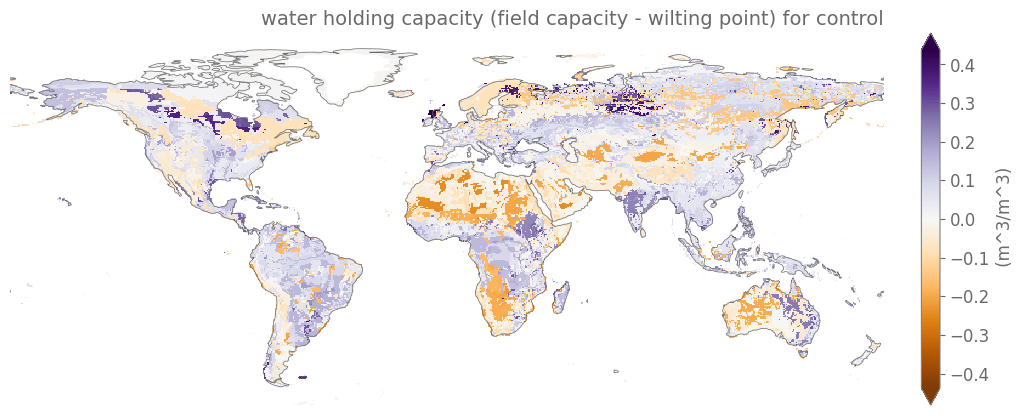

In [78]:
vlims=d_vlims[variable]

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

(da_fc_ctl - da_wilting_h2osoi).mean('time').weighted(da_wilting_h2osoi['levsoi']).mean(dim='levsoi').plot(ax=ax, cmap='PuOr', extend='both',  cbar_kwargs={'label': ' ('+da_fc_ctl.units+')', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)

ax.set_title('water holding capacity (field capacity - wilting point) for control', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')
    

### Same but for water content at saturation

In [79]:
# delta field capacity
da_sat_ctl =  ds_ctl['watsat'][:,0:10,:,:].rename({'levgrnd':'levsoi'})
da_sat_scen =  ds_scen['watsat'][:,0:10,:,:].rename({'levgrnd':'levsoi'})

da_sat_ctl['levsoi'] = da_wilting_h2osoi_scen['levsoi']
da_sat_scen['levsoi'] = da_wilting_h2osoi_scen['levsoi']

da_whc_ctl =  (da_sat_ctl - da_wilting_h2osoi).where((da_sat_ctl - da_wilting_h2osoi)> 0)
da_whc_scen = (da_sat_scen  - da_wilting_h2osoi_scen).where((da_sat_ctl - da_wilting_h2osoi)> 0)

# delta wilting point
da_delta_whc =  da_whc_scen - da_whc_ctl
da_delta_whc = da_delta_whc.weighted(da_delta_whc['levsoi']).mean(dim='levsoi')
da_whc_ctl= da_whc_ctl.weighted(da_whc_ctl['levsoi']).mean(dim='levsoi')


(-180.0, 180.0, -63.0, 90.0)

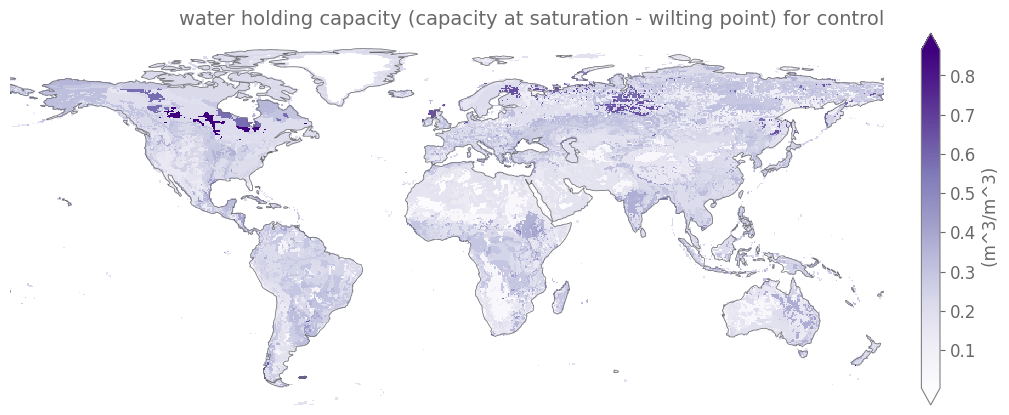

In [82]:
vlims=d_vlims[variable]

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

(da_sat_ctl - da_wilting_h2osoi).mean('time').weighted(da_wilting_h2osoi['levsoi']).mean(dim='levsoi').plot(ax=ax, cmap='Purples', extend='both',  cbar_kwargs={'label': ' ('+da_fc_ctl.units+')', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)

ax.set_title('water holding capacity (capacity at saturation - wilting point) for control', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')
    

(-180.0, 180.0, -63.0, 90.0)

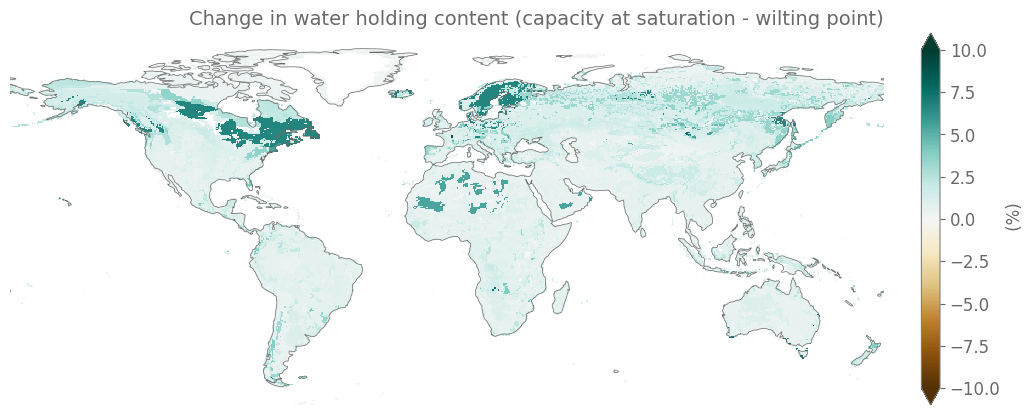

In [84]:
# plot water holding capacity of the soil (FC - permanent wilting point) 

da_delta_whc.attrs = {'long_name': 'Change in water holding content (capacity at saturation - wilting point)', 'units': 'm^3/m^3'}

vlims=[-10,10]

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

((da_delta_whc/da_whc_ctl).mean('time')*100).plot(ax=ax, cmap='BrBG', extend='both',  vmin=vlims[0], vmax=vlims[1],  cbar_kwargs={'label':' (%)', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)

ax.set_title(da_delta_whc.long_name, loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')
    

In [ ]:
d_vlims = {"watfc"         : [-0.0001,0.0001], 
           "watsat"        : [-0.0001,0.0001], 
           "H2OSOI"         : [-0.001,0.001],
           "H2OSOI_WILT"  : [-0.001,0.001]}

    
variable = 'H2OSOI_WILT'

# plot this variable seperate
da_delta =  da_wilting_h2osoi_scen - da_wilting_h2osoi

if 'levsoi' in da_delta.dims: 
    da_delta = da_delta.weighted(da_delta['levsoi']).mean(dim='levsoi')

da_delta.attrs = {'long_name': 'permanent wilting point', 'units': 'm^3/m^3'}

vlims=d_vlims[variable]

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

da_delta.plot(ax=ax, cmap='BrBG',extend='both',  vmax= 0.001, cbar_kwargs={'label': da_delta.name+' ('+da_delta.units+')', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)

ax.set_title(da_delta.long_name, loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')
    

In [ ]:
# saturation ratio
variable = 'watfc'
pft_list = pft_list_crops

flag_calc_regionmeans = True

if flag_calc_regionmeans: 

    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, mask_regions)


In [ ]:
# saturation ratio
variable = 'watsat'
pft_list = pft_list_crops

flag_calc_regionmeans = True

if flag_calc_regionmeans: 

    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, mask_regions)


In [ ]:
# saturation ratio
variable = 'H2OSOI'
pft_list = pft_list_crops

flag_calc_regionmeans = True

if flag_calc_regionmeans: 

    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, mask_regions)


In [ ]:
# saturation ratio
variable = 'H2OSOI'
pft_list = pft_list_crops

flag_calc_regionmeans = True

if flag_calc_regionmeans: 

    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, mask_regions)


In [ ]:
#save_regionalmean_delta_and_delta_rel

for pft_int in pft_list: 
        print('processing pft: '+str(pft_int))

        # calculate delta and relative delta of saturation ratio. 
        da_delta, da_delta_rel = calc_delta_and_rel_pft_3d(case_ctl, case_scen, variable, pft_int)
        
        if not isinstance(texture_mask,bool): 
            da_delta = da_delta.squeeze().where(texture_mask.compute(), drop=True)
            da_delta_rel = da_delta_rel.squeeze().where(texture_mask.compute(), drop=True)

            texture_name = texture_mask.name
            print(texture_name)
        
        # calculate regional means. 
        ds_regions = calc_regionalmeans(da_delta, region_ids, mask_regions)

        del da_delta

        ds_regions.to_netcdf(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change.nc')

        # calculate regional means. 
        ds_regions_rel = calc_regionalmeans(da_delta_rel, region_ids, mask_regions)

        del da_delta_rel

        ds_regions_rel.to_netcdf(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change_rel.nc')

        print()


In [29]:
# saturation ratio
variable = 'H2OSOI'
pft_list = pft_list_crops

flag_calc_regionmeans = False

if flag_calc_regionmeans: 
    
    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, mask_regions)

